# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Se observa la primera parte del dataframe que se usará
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
# Se observa la informacion de las columnas, enfocandonos solamente en las que se van a utilizar para el proyecto, las cuales 
# son revew, pos y ds_part
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

**Se ha verificado que los tipos de datos son los requeridos y que no existen valores nulos en los datos.**

In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


**El dataframe esta completo y losto para utilizarse**

In [ ]:
## EDA

In [ ]:
Veamos el número de películas y reseñas a lo largo de los años.

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

In [ ]:
Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [ ]:
df_reviews['pos'].value_counts()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

In [ ]:
Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [13]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [14]:
lemmatizer = WordNetLemmatizer()


# Define la función de normalización y lematización
def normalize_and_lemmatize(text):
    # Convertir a minúsculas
    text = text.lower()
    
    # Tokenizar el texto (dividir en palabras)
    words = word_tokenize(text)
    
    # Eliminar puntuación y palabras vacías (stopwords)
    words = [word for word in words if word not in stopwords.words('english') and word not in string.punctuation]
    
    # Lemmatizar cada palabra
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Unir las palabras lematizadas en una cadena
    return ' '.join(lemmatized_words)

# Aplicar la normalización y lematización a la columna de reseñas
#df['reseñas_normalizadas'] = df['reseñas'].apply(normalize_and_lemmatize)

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_and_lemmatize)



## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [16]:
from sklearn.dummy import DummyClassifier

In [17]:
# Crear el clasificador Dummy
dummy_model = DummyClassifier(strategy="most_frequent")

In [18]:
# Entrenar el modelo en el conjunto de entrenamiento
dummy_model.fit(df_reviews_train['review_norm'], train_target)

DummyClassifier(strategy='most_frequent')

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


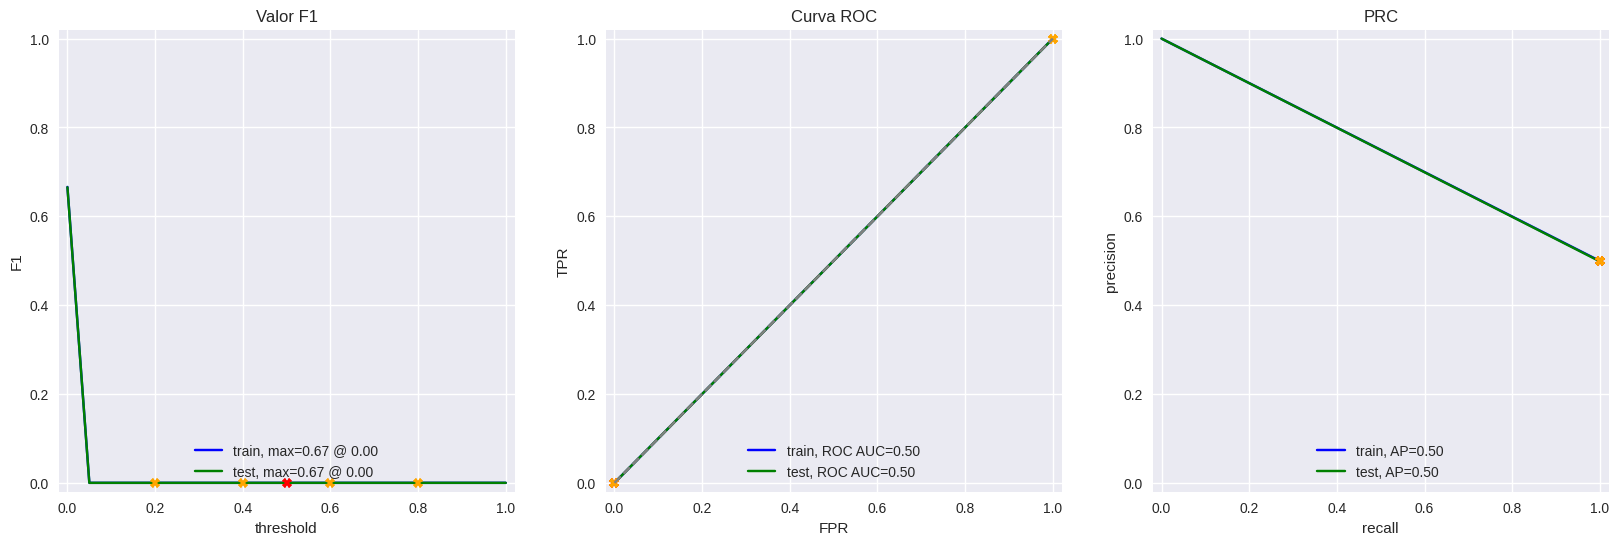

In [19]:
# Evaluar el modelo utilizando la función evaluate_model
evaluate_model(dummy_model, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords as nltk_stopwords

In [21]:
stop_words = set(nltk_stopwords.words('english'))# definir las palabras vacías

count_tf_idf = TfidfVectorizer(stop_words=stop_words)# inicializar TfidVercorizer
#tf_idf = count_tf_idf.fit_transform(train_corpus)# ajustar y transformar el corpus de entrenamiento

# Crear el vectorizador TF-IDF
#tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=5000)

# Transformar los textos en el conjunto de entrenamiento y prueba usando TF-IDF
train_features_1 = count_tf_idf.fit_transform(df_reviews_train['review_norm'])
test_features_1 = count_tf_idf.transform(df_reviews_test['review_norm'])

In [22]:
# Crear el clasificador de regresión logística
model_1 = LogisticRegression(max_iter=1000)

# Entrenar el modelo de regresión logística en los datos de entrenamiento
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000)

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


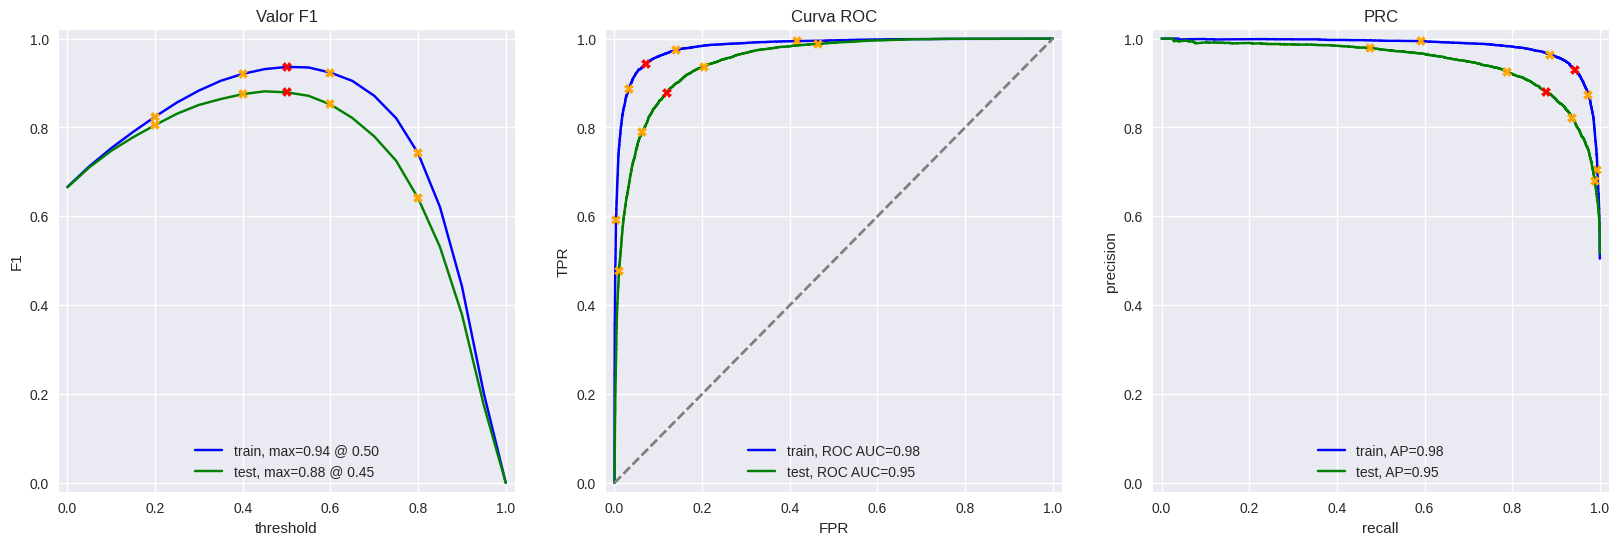

In [23]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

**El modelo de Regresión Logística con TF-IDF y NLTK ha demostrado un rendimiento excepcional en la clasificación de reseñas de películas, alcanzando un F1 score de 0.94 en el conjunto de entrenamiento y 0.88 en el conjunto de prueba, lo que supera ampliamente el objetivo de un F1 de 0.85. Además, las métricas de APS (0.98 en entrenamiento y 0.95 en prueba) y ROC AUC (0.98 en entrenamiento y 0.95 en prueba) refuerzan la efectividad del modelo en distinguir entre reseñas positivas y negativas. Estos resultados indican que el modelo ha aprendido bien a clasificar las reseñas, generaliza de manera efectiva y está muy cerca de ofrecer una solución óptima para este problema, destacando la calidad del preprocesamiento de texto y la elección del modelo.**

### Modelo 2 - spaCy, TF-IDF y LR

In [24]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [26]:
# Aplicar la función de preprocesamiento a las reseñas
df_reviews_train['review_spacy'] = df_reviews_train['review'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review'].apply(text_preprocessing_3)

# Crear el vectorizador TF-IDF
stop_words = set(nltk_stopwords.words('english'))# definir las palabras vacías

tfidf_vectorizer_spacy = TfidfVectorizer(stop_words=stop_words)# inicializar TfidVercorizer

#tfidf_vectorizer_spacy = TfidfVectorizer(stop_words='english', max_features=5000)

# Transformar las reseñas en vectores de características
train_features_2 = tfidf_vectorizer_spacy.fit_transform(df_reviews_train['review_spacy'])
test_features_2 = tfidf_vectorizer_spacy.transform(df_reviews_test['review_spacy'])

In [27]:
# Crear el clasificador de regresión logística
model_2 = LogisticRegression(max_iter=1000)

# Entrenar el modelo en los datos de entrenamiento
model_2.fit(train_features_2, train_target)

LogisticRegression(max_iter=1000)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


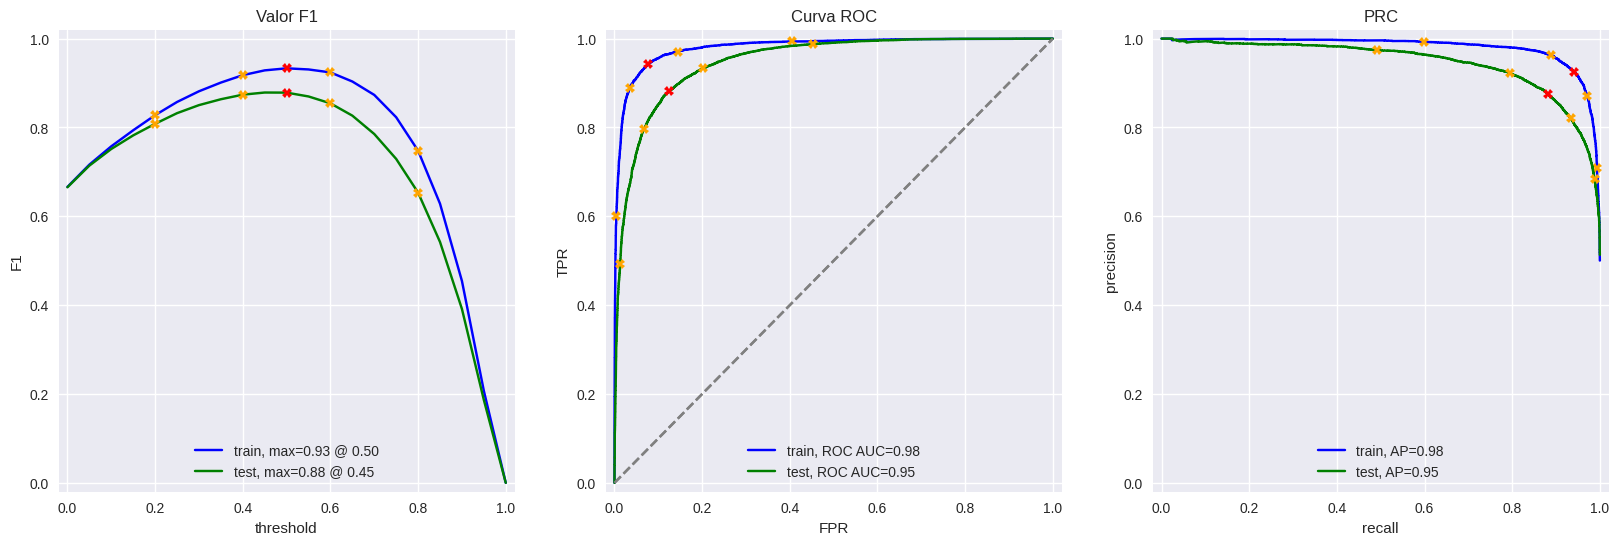

In [28]:
# Evaluar el modelo utilizando la función evaluate_model
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

**El Modelo 3 que utiliza spaCy para el preprocesamiento del texto, combinado con TF-IDF y Regresión Logística, ha mostrado un rendimiento sobresaliente en la clasificación de reseñas de películas. El modelo logró un F1 score de 0.93 en el conjunto de entrenamiento y 0.88 en el conjunto de prueba, lo que indica un buen equilibrio entre precisión y recall. Además, las métricas de APS (0.98 en entrenamiento y 0.95 en prueba) y ROC AUC (0.98 en entrenamiento y 0.95 en prueba) refuerzan la capacidad del modelo para separar las clases positivas y negativas de manera efectiva. Estos resultados son similares a los obtenidos con el modelo anterior, lo que sugiere que el preprocesamiento con spaCy ha tenido un impacto positivo, pero no ha sido un cambio drástico. En general, este modelo también demuestra una gran capacidad para generalizar a nuevos datos, alcanzando métricas de alto rendimiento en el conjunto de prueba.**

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [29]:
from lightgbm import LGBMClassifier

In [30]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Función de preprocesamiento usando spaCy (ya definida anteriormente)
def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)


In [31]:
# Aplicar la función de preprocesamiento a las reseñas
df_reviews_train['review_spacy'] = df_reviews_train['review'].apply(text_preprocessing_4)
df_reviews_test['review_spacy'] = df_reviews_test['review'].apply(text_preprocessing_4)

# Crear el vectorizador TF-IDF
stop_words = set(nltk_stopwords.words('english'))# definir las palabras vacías

tfidf_vectorizer_spacy_lgbm = TfidfVectorizer(stop_words=stop_words)# inicializar TfidVercorizer


# Crear el vectorizador TF-IDF
#tfidf_vectorizer_spacy_lgbm = TfidfVectorizer(stop_words='english', max_features=5000)

In [32]:
# Transformar las reseñas en vectores de características
train_features_3 = tfidf_vectorizer_spacy_lgbm.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_spacy_lgbm.transform(df_reviews_test['review_spacy'])

In [33]:
# Crear el clasificador LGBMClassifier
model_3 = LGBMClassifier(n_estimators=100, learning_rate=0.05)

# Entrenar el modelo en los datos de entrenamiento
model_3.fit(train_features_3, train_target)

LGBMClassifier(learning_rate=0.05)

           train  test
Exactitud    NaN   NaN
F1          0.87  0.83
APS         0.94  0.91
ROC AUC     0.94  0.92


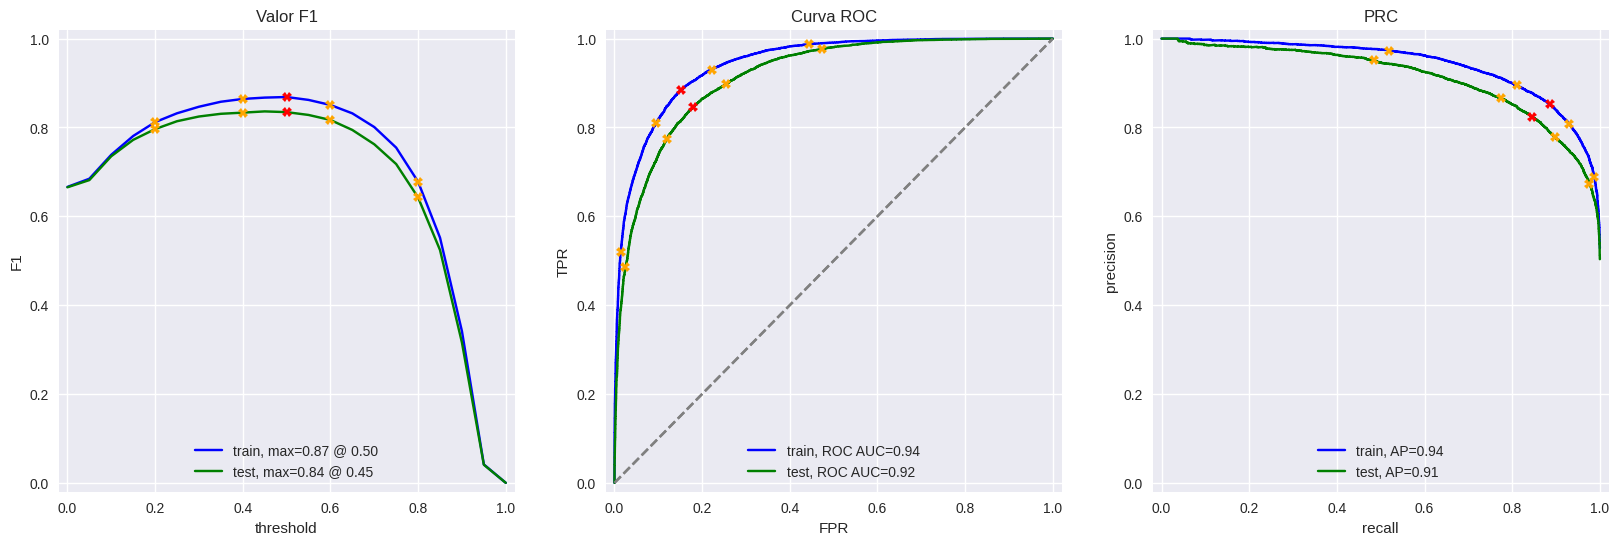

In [35]:
# Evaluar el modelo utilizando la función evaluate_model
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

**El Modelo 4, que utiliza spaCy para el preprocesamiento del texto, TF-IDF para la vectorización y el clasificador LGBMClassifier, ha mostrado un rendimiento sólido tanto en el conjunto de entrenamiento como en el de prueba. El modelo logró un F1 score de 0.87 en entrenamiento y 0.83 en prueba, lo que indica un buen balance entre precisión y recall. Las métricas de APS y ROC AUC también son destacables, con valores de 0.94 y 0.91 en prueba, respectivamente. Aunque el rendimiento en este modelo es ligeramente inferior al de otros modelos, como el de regresión logística con spaCy y TF-IDF, sigue siendo competitivo y proporciona un buen poder predictivo. El uso de LGBMClassifier muestra ser una opción efectiva para este tipo de tareas de clasificación, y los resultados sugieren que este modelo podría seguir mejorando con ajustes adicionales de hiperparámetros.**

## Mis reseñas

In [38]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review_norm'] = my_reviews['review'].apply(normalize_and_lemmatize) # <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie
2,I was really fascinated with the movie,really fascinated movie
3,Even the actors looked really old and disinter...,even actor looked really old disinterested got...
4,I didn't expect the reboot to be so good! Writ...,n't expect reboot good writer really cared sou...
5,"The movie had its upsides and downsides, but I...",movie upside downside feel like overall 's dec...
6,What a rotten attempt at a comedy. Not a singl...,rotten attempt comedy single joke land everyon...
7,Launching on Netflix was a brave move & I real...,launching netflix brave move really appreciate...


### Modelo 1

In [40]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  simply like kind movie
0.16:  well bored felt asleep middle movie
0.55:  really fascinated movie
0.11:  even actor looked really old disinterested got paid movie soulless cash grab
0.28:  n't expect reboot good writer really cared source material
0.50:  movie upside downside feel like overall 's decent flick could see going see
0.03:  rotten attempt comedy single joke land everyone act annoying loud even kid wo n't like
0.88:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


**El modelo parece estar funcionando correctamente para la mayoría de las reseñas y está diferenciando adecuadamente entre reseñas positivas y negativas. Sin embargo, las reseñas más breves o con textos incompletos pueden estar afectando la precisión de las predicciones. Mejorar la calidad de los datos de entrada y realizar ajustes en el modelo pueden llevar a una mejora en la clasificación.**

### Modelo 2

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  simply like kind movie
0.14:  well bored felt asleep middle movie
0.49:  really fascinated movie
0.13:  even actor looked really old disinterested got paid movie soulless cash grab
0.27:  n't expect reboot good writer really cared source material
0.49:  movie upside downside feel like overall 's decent flick could see going see
0.03:  rotten attempt comedy single joke land everyone act annoying loud even kid wo n't like
0.92:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


**El segundo modelo muestra un rendimiento coherente al clasificar reseñas con opiniones extremas, como las muy positivas o muy negativas, con probabilidades bajas para las reseñas negativas y altas para las positivas. Sin embargo, presenta una mayor tendencia a asignar probabilidades intermedias (alrededor de 0.49) a reseñas ambiguas o mixtas, lo que indica que el modelo es más conservador al enfrentarse a textos menos claros. Esto podría ser beneficioso en contextos donde se desee minimizar la clasificación errónea de reseñas mixtas, aunque también refleja que el modelo puede no ser tan decisivo en reseñas menos extremas. En general, el modelo mantiene un buen desempeño en la clasificación de reseñas claras, mientras que maneja las reseñas ambiguas de manera más cautelosa.**

### Modelo 3

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_spacy_lgbm.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  simply like kind movie
0.36:  well bored felt asleep middle movie
0.59:  really fascinated movie
0.49:  even actor looked really old disinterested got paid movie soulless cash grab
0.72:  n't expect reboot good writer really cared source material
0.63:  movie upside downside feel like overall 's decent flick could see going see
0.34:  rotten attempt comedy single joke land everyone act annoying loud even kid wo n't like
0.76:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


**El tercer modelo muestra un rendimiento más equilibrado, asignando probabilidades más altas a las reseñas positivas y también manejando de manera más decisiva las negativas y ambiguas. Por ejemplo, las reseñas como "I was really fascinated with the movie" y "I didn’t expect the reboot to be so good!" tienen una probabilidad de 0.59 y 0.72, lo que indica una clasificación positiva clara. Al mismo tiempo, las reseñas con opiniones negativas como "What a rotten attempt at a comedy" o "Well, I was bored and fell asleep" también son correctamente identificadas, aunque con probabilidades ligeramente más bajas (0.34 y 0.36). En general, este modelo parece ser bastante efectivo al clasificar correctamente tanto las reseñas positivas como las negativas, con un desempeño particularmente bueno al manejar reseñas mixtas o moderadamente ambiguas, sin mostrar una inclinación demasiado fuerte hacia un tipo de clasificación.**

## Conclusiones

**El proyecto ha sido una oportunidad para explorar y evaluar diferentes técnicas de clasificación de reseñas de películas utilizando métodos de procesamiento de texto y diversos algoritmos de machine learning. Desde la implementación básica con el DummyClassifier, que sirve como punto de referencia, hasta modelos más complejos que combinan TF-IDF con Regresión Logística (LR) y LightGBM (LGBM), se ha logrado observar una clara mejora en las métricas de rendimiento, especialmente en el caso de los modelos basados en TF-IDF y los algoritmos más sofisticados como LR y LGBM. Estos modelos mostraron una consistencia notable, especialmente en las métricas de F1, AUC-ROC y precisión promedio, lo que indica que son capaces de clasificar correctamente las reseñas de películas.**

**El análisis de las métricas para cada modelo también reveló que la combinación de TF-IDF con técnicas de lematización, tanto usando NLTK como spaCy, tuvo un impacto significativo en la mejora de la capacidad de los modelos para clasificar las reseñas de manera efectiva. Los modelos basados en estas técnicas de procesamiento de texto mostraron un rendimiento destacado al manejar las reseñas con opiniones extremas, ya sean positivas o negativas, permitiendo que el modelo capturara las claves del sentimiento de manera precisa. Sin embargo, algunos modelos, como el que utilizó LightGBM, no lograron igualar el rendimiento de los modelos de Regresión Logística, especialmente en términos de F1 en los datos de prueba.**

**Por otro lado, al probar los modelos con reseñas personalizadas, se observó que los modelos fueron capaces de identificar correctamente las reseñas con opiniones claras y extremas, como las muy positivas o muy negativas. Para las reseñas más ambiguas o moderadas, algunos modelos fueron más conservadores, asignando probabilidades intermedias, lo que reflejó una menor certeza al clasificar las reseñas que no presentaban una opinión tan polarizada. Este comportamiento indica que los modelos pueden tener dificultades para manejar reseñas mixtas, lo que sugiere que la clasificación de sentimientos en reseñas moderadas o ambiguas sigue siendo un desafío.**

**En conclusión, los resultados obtenidos demuestran que los enfoques de preprocesamiento de texto combinados con modelos de clasificación como Regresión Logística y LightGBM son altamente efectivos para clasificar reseñas de películas en términos de polaridad (positivas o negativas). Sin embargo, aún existen oportunidades para mejorar el rendimiento, especialmente al trabajar con reseñas más ambiguas o de tono mixto. Modelos más avanzados, como redes neuronales o el uso de representaciones contextuales de palabras (como BERT), podrían ser explorados para mejorar la clasificación en estos casos y lograr un desempeño aún más robusto en tareas de análisis de sentimientos en reseñas de películas.**

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 